In [ ]:
!pip install cupy
!pip install numpy
!pip install mtalg
# !pip install pickle
!pip install tqdm
!pip install scipy
# import cupy as cp
!pip install matplotlib
!pip install dill

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v4, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023

In [1]:
# import os, pathlib, pickle, gzip, numpy as np

# fn = f"data/data_set_clean_1.pickle"
# p = pathlib.Path(fn)
# print("ABS:", p.resolve())
# print("Exists:", p.exists(), "Size:", p.stat().st_size if p.exists() else 0)

# with open(fn, "rb") as f:
#     head = f.read(16)
# print("First 16 bytes:", head)
# with open(f"data/data_set_clean_1.pickle", "rb") as f:
#     data=pickle.load(f) 
# data

In [2]:
# # ==== CuPy GPU smoke test ====
# import cupy as cp

# print("CuPy version:", cp.__version__)

# # Show device properties
# props = cp.cuda.runtime.getDeviceProperties(0)
# print("GPU:", props["name"].decode(), 
#       "| Compute capability:", props["major"], props["minor"])

# # Simple array operation (checks CUDA runtime)
# x = cp.arange(5, dtype=cp.float32)
# print("x:", x.get(), "-> x^2:", (x**2).get())

# # Tiny RawKernel (checks NVRTC/NVCC + headers)
# code = r"""
# extern "C" __global__ void add1(float* a, int n){
#   int i = blockDim.x * blockIdx.x + threadIdx.x;
#   if(i<n) a[i] += 1.0f;
# }
# """
# ker = cp.RawKernel(code, "add1")
# y = cp.zeros(128, dtype=cp.float32)
# ker((1,), (128,), (y, y.size))
# print("RawKernel add1 sum:", float(y.sum()))


In [3]:
# %env CUPY_NVCC_GENERATE_CODE=arch=compute_90,code=sm_90
# %env CUPY_CUDA_COMPILE_WITH_PTX=1
# import cupy as cp
# print("CuPy:", cp.__version__)
# cp.show_config()

# # tiny GPU test
# x = cp.arange(5)
# print("x^2:", (x**2).get())

In [4]:
# ==== Alliance / H100 / cudacore 12.6.2 setup ====
import os

CUDA_ROOT = "/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2"

INC1 = f"{CUDA_ROOT}/include"
INC2 = f"{CUDA_ROOT}/targets/x86_64-linux/include"
LIB1 = f"{CUDA_ROOT}/lib64"
LIB2 = f"{CUDA_ROOT}/targets/x86_64-linux/lib"
BIN  = f"{CUDA_ROOT}/bin"

# Arch for H100 (sm_90)
os.environ["CUPY_NVCC_GENERATE_CODE"] = "arch=compute_90,code=sm_90"

# Tell CuPy/NVRTC where CUDA lives
os.environ["EBROOTCUDA"] = CUDA_ROOT
os.environ["CUPY_CUDA_ROOT"] = CUDA_ROOT
os.environ["CUPY_CUDA_PATH"] = CUDA_ROOT
os.environ["CUPY_CUDA_INCLUDE_DIRS"] = f"{INC1}:{INC2}"

# Make the dynamic loader see CUDA libs
os.environ["LD_LIBRARY_PATH"] = f"{LIB1}:{LIB2}:" + os.environ.get("LD_LIBRARY_PATH","")

# Ensure nvcc is on PATH (for the NVCC backend fallback)
os.environ["PATH"] = f"{BIN}:" + os.environ.get("PATH","")

# Pass include paths directly to NVRTC as well
os.environ["CUPY_NVRTC_EXTRA_OPTIONS"] = f"--include-path={INC1},--include-path={INC2}"

print("CUDA_ROOT =", CUDA_ROOT)
print("Includes  =", INC1, "|", INC2)
print("Libs      =", LIB1, "|", LIB2)
print("nvcc path =", os.popen("which nvcc || true").read().strip())


CUDA_ROOT = /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2
Includes  = /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2/include | /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2/targets/x86_64-linux/include
Libs      = /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2/lib64 | /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2/targets/x86_64-linux/lib
nvcc path = /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2/bin/nvcc


In [6]:
import os
import cupy as cp
cp.show_config()

# ---- Try NVRTC (default) with explicit include options ----
from cupy.cuda.compiler import CompileException

code = r"""
extern "C" __global__ void add1(float* a, int n){
  int i = blockDim.x * blockIdx.x + threadIdx.x;
  if(i<n) a[i] += 1.0f;
}
"""

print("\n[1] NVRTC backend test...")
try:
    mod = cp.RawModule(
        code=code,
        options=(
            f"--include-path={os.environ['EBROOTCUDA']}/include",
            f"--include-path={os.environ['EBROOTCUDA']}/targets/x86_64-linux/include",
        ),
        backend='nvrtc'
    )
    add1 = mod.get_function("add1")
    x = cp.zeros(256, dtype=cp.float32)
    add1((2,), (128,), (x, x.size))
    print("  NVRTC OK. sum:", float(x.sum()))
except CompileException as e:
    print("  NVRTC compile failed.\n---- NVRTC LOG START ----")
    print(e)
    print("---- NVRTC LOG END ----")

# ---- If NVRTC fails, try NVCC backend ----
print("\n[2] NVCC backend test...")
try:
    mod2 = cp.RawModule(code=code, options=("-std=c++14",), backend='nvcc')
    add1b = mod2.get_function("add1")
    y = cp.zeros(256, dtype=cp.float32)
    add1b((2,), (128,), (y, y.size))
    print("  NVCC OK. sum:", float(y.sum()))
except CompileException as e:
    print("  NVCC compile failed.\n---- NVCC LOG START ----")
    print(e)
    print("---- NVCC LOG END ----")


OS                           : Linux-5.14.0-570.22.1.el9_6.x86_64-x86_64-AMD_EPYC_9454_48-Core_Processor-with-glibc2.37
Python Version               : 3.11.5
CuPy Version                 : 13.3.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 2.2.2
SciPy Version                : 1.15.2
Cython Build Version         : 0.29.36
Cython Runtime Version       : None
CUDA Root                    : /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2
nvcc PATH                    : /cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v3/Core/cudacore/12.6.2/bin/nvcc
CUDA Build Version           : 12020
CUDA Driver Version          : 13000
CUDA Runtime Version         : 12020 (linked to CuPy) / RuntimeError('CuPy failed to load libcudart.so.12: OSError: libcudart.so.12: cannot open shared object file: No such file or directory') (locally installed)
CUDA Extra Include Dirs      : []
cuBLAS Version               : (available)
cuFFT Ve

In [7]:
import numpy as np
from mtalg.random import MultithreadedRNG
# import pickle
import dill as pickle
from tqdm import tqdm
import scipy
# import cupy as cp
import matplotlib.pyplot as plt
from matplotlib import cm
import PD_Median_Functions_opt_for_sims
viridis = cm.get_cmap('viridis', 8)

/tmp/ipykernel_1661692/949192973.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 8)


In [8]:
####################################################################
###################### Functions for s-IDD #########################
####################################################################
# This is the expit or sigmoid function with smoothing parameter "smooth" (1+exp(-smooth*x))^{-1}
def expit(x,smooth):
    return scipy.special.expit(x*smooth)

# Computes the smoothed integrated dual depth
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# n: integer sample size
def idd_beta(x,smooth,pj_data,u,n):
    # pj_data=np.matmul(data,u)
    pj_x=np.matmul(u,x)
    # Now for each u find univariate depth and average, u are the columns
    depth= expit(pj_x-pj_data,smooth)
    depth= np.sum(depth,0)/n
    depth= depth*(1-depth)
    depth= np.mean(depth)
    return depth


# Computes the gradient of the smoothed integrated dual depth
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# m: integer number of unit vectors sampled
# n: integer sample size
def grad_depth(x,pj_data,u,smooth,n,m):
    x=cp.asarray(x)
    # pj_data=np.matmul(data,u)
    # pj data is n  x m
    # pj x is m x 1
    # x is d x 1
    # u m x d
    pj_x=cp.matmul(u,x)
    #expits is n x m 
    expits=expit(pj_x-pj_data,smooth)  
    term1= expits*(1-expits)
    # sum/mean along the columns now
    term1=cp.sum(term1,0)/n
    term2=1-2*cp.sum(expits,0)/n
    ddx=term1*term2*smooth
    # Now ddx is "1 x m" but is a vector
    # multiply each column of u by ddx 
    grad=(u.T)*ddx
    grad=cp.sum(grad,1)/m
    # final=n*eps* uv/2
    return cp.asnumpy(grad)


#Gradient of the log density of a normal prior 
# x: d x 1 numpy array for point at which depth is computed
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
def grad_prior(x,prior_mean,prior_cov_inv):
    return -np.matmul(x-prior_mean,prior_cov_inv)


# Gradient descent algorithm for computing the non-private smoothed IDD median 
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# m: integer number of unit vectors sampled
# n: integer sample size
# eps: pure privacy parameter
def GD_update(x,step,d,pj_data,smooth,n,m,unit_vectors):
    return x+step*(grad_depth(x,pj_data,unit_vectors,smooth,n,m))

######
### one step of langevin dynamics
## 
# x: d x 1 numpy array for point at which depth is computed
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# d: integer dimension
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# n: integer sample size
# m: integer number of unit vectors sampled
# unit_vectors: m x d numpy array of uniformly sampled unit vectors
# eps: pure privacy parameter
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
# mrng: this is the seed for the mtalg package
def langevin_update(x,step,sqrt2step,d,pj_data,smooth,n,m,unit_vectors,eps,prior_mean,prior_cov_inv,mrng):
    prior_grad=grad_prior(x,prior_mean,prior_cov_inv)
    depth_grad=grad_depth(x,pj_data,unit_vectors,smooth,n,m)
    # beta=eps*n/6 ensures eps-DP for smoothed IDD 
    return x+step*(prior_grad+depth_grad*eps*n/6)+sqrt2step*mrng.standard_normal(size=d)

####################################################################

In [9]:
# This function returns one run of the simulation experiment for a given run_number
# OUTPUT:
# x_p:  the Markov chain for the private median 
# x_np: the iterations of the gradient descent for the non-private median 
# x:  the Markov chain for the private s median 
# x2: the iterations of the gradient descent for the non-private s median 
# cp: coin-press mean 
# INPUT: 
# run_number: the number from 1-50 corresponding to the simulation run
# fn_dict: functions to compute values associated with the type of pd median for faster simulation, see example below
# d: integer dimension
# tau: tau parameter for priv pd median
# eta: eta parameter for priv pd median
# eps: privacy parameter
# rho: rho for coinpress
# delta: delta privacy parameter
# nvec: integer number of unit vectors sampled
# ndata: integer sample size
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private medians
# step_l: step size for the langevin dynamics for the private medians
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation, this is clean for the heavy tail scenario

def experiment(run_number,fn_dict,d,tau,eta,eps,rho,delta,nvec,n_steps_mc,step_l,data_type,ndata):
    # set the seed for the langevin dynamics to be the run number
    # this way we can reproduce the chain 
    # only use 1 thread because we are on the gpu
    mrng = MultithreadedRNG(seed=run_number, num_threads=1)
    
    ####################################################################
    # load in data, unit vectors and starting value
    # print("data/data_set_"+data_type+"_"+str(run_number)+".pickle")
    with open("data/data_set_"+data_type+"_"+str(run_number)+".pickle",'rb') as file:
        data=pickle.load(file)
    data=data[0:ndata,0:d]
    
    ####################################################################
    with open("unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        unit_vectors=pickle.load(file)
    unit_vectors=unit_vectors[0:nvec,:]
    
    ####################################################################
    with open("starting/starting_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        x0=pickle.load(file)

    # move data to GPU
    data=cp.asarray(data)
    x00=x0.copy()
    x0=cp.asarray(x0)
    # x00=cp.asarray(x00)
    unit_vectors=cp.asarray(unit_vectors)

    # compute the projections of the data onto the randomly drawn unit vectors
    pj_data=cp.matmul(unit_vectors,data.T).T

    ######################### PD Medians ###########################################
    IV=PD_Median_Functions_opt_for_sims.get_initial_values(unit_vectors,data,fn_dict['mu'],fn_dict['sigma'])
    ###### MCMC-lagevin dyanmics for private median
    x_p=PD_Median_Functions_opt_for_sims.compute_PTR_PD_Median(data,fn_dict,tau,eta,eps,delta,IV=IV,
                            nvec=unit_vectors.shape[0],mrng=mrng,step_l=step_l,nstep=n_steps_mc,u=unit_vectors,x0=x0,return_chain=True,joint=True)
    
    ######################### s-IDD Medians ###########################################
    ## Let's do IDD Median
    # Smooth param
    smooth=10
    
    ###### MCMC-lagevin dyanmics for private median
    prior_mean=np.zeros(d)
    prior_cov_inv=np.eye(d)/25*np.sqrt(d)
    x = []
    x.append(x00)
    sqrt2step = np.sqrt(2*step_l)
    for t in range(n_steps_mc):
        x.append(langevin_update(x[-1],step_l,sqrt2step,d,pj_data,smooth,ndata,nvec,unit_vectors,eps,prior_mean,prior_cov_inv,mrng))
    
    return x_p,x


In [10]:

# This function plots and saves the results from each experiment. 
# It writes the progression of the GD and MCMC to text files, the mean to a text file
# It plots the chains over time 
# INPUT: 
# results: list of results from 50 runs of the simulations
# d: integer dimension
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private median
# step_l: step size for the langevin dynamics for the private median
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation
def plot_and_save(results,d,n_steps_mc,data_type='clean',tag='unsp'):
    pr_est=np.zeros(d)
    np_est=np.zeros(d)
    colors= viridis(range(8))
    count=0
    for i in results:
        x_p,x = i
        ## PD Median
        #pr
        x_p = [xx.get() for xx in x_p]
        x_p = np.vstack(x_p)
        norm_x_p = np.linalg.norm(x_p,axis=1)
        pr_est=x_p[-1,:]
        # S-IDD
        x = [xx for xx in x]
        x = np.vstack(x)
        norm_x = np.linalg.norm(x,axis=1)
        pr_idd_est=x[-1,:]
        if count==0:
            plt.plot(np.arange(n_steps_mc+1),norm_x_p,color=colors[0],label=r'private pd median')
            plt.ylabel('estimate norm', fontsize=18)
            plt.xlabel('time step', fontsize=18)
            plt.legend(fontsize=18)
        else:
            plt.plot(np.arange(n_steps_mc+1),norm_x_p,color=colors[0])
        plt.plot(np.arange(n_steps_mc+1),norm_x,color=colors[3])
        count=count+1
    # plt.show()
    #save the plot
    fname='out_img/'+tag+'_pd_dimension_'+str(d)+"_"+data_type+"_med_eps.png"
    plt.savefig(fname,dpi=600)
    plt.show()
    ##### save the estimates to a csv
    ## private pdd
    fn_p="output/"+tag+"_private_pd_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps.csv"
    fn_p=open(fn_p, 'w', newline='')
    np.savetxt(fn_p, pr_est, delimiter=",")   
    fn_p.close()
    ## sIDD p
    fn_p="output/"+tag+"_private_sidd_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps.csv"
    fn_p=open(fn_p, 'w', newline='')
    np.savetxt(fn_p, pr_idd_est, delimiter=",")   
    fn_p.close()



In [11]:
# experiment parameters

num_runs=int(50)
# num_runs=int(2)
ndata=50000
nvecs=[500,500,1000]
nsteps_mc=[500,1000,1500]
mc=0.00015
mc_step_sizes=[mc,mc,mc]
dimensions=[2,10,20]

In [12]:
# Used as inpute into experiment, these functions compute various quantities associated with the location and scale chosen, see manuscript

fn_dict_med_mad={
     'mu': PD_Median_Functions_opt_for_sims.med,
     'sigma': PD_Median_Functions_opt_for_sims.mad,
     'Smu': PD_Median_Functions_opt_for_sims.S_med,
     'Ssigma': PD_Median_Functions_opt_for_sims.S_mad,
     'bhat': PD_Median_Functions_opt_for_sims.b_hat_mad,
     'joint': PD_Median_Functions_opt_for_sims.S_med_mad_b_joint,
     'mad_flag': True
}


starting dimension 2


100%|██████████| 50/50 [29:15<00:00, 35.12s/it]


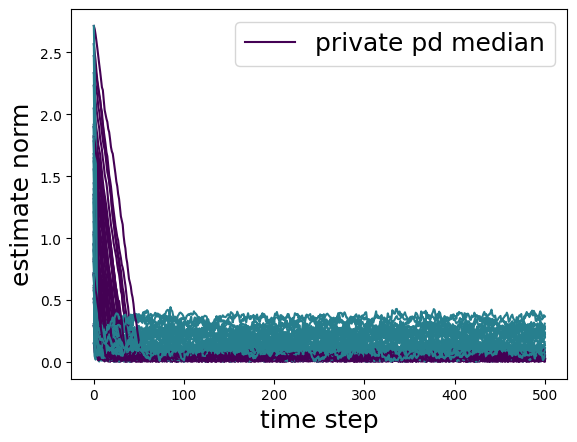

starting dimension 10


100%|██████████| 50/50 [33:09<00:00, 39.79s/it]


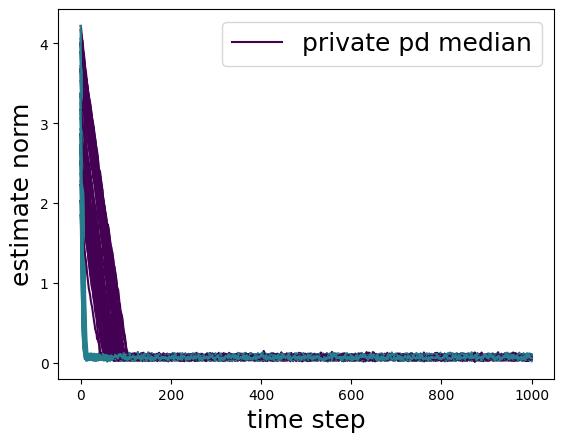

starting dimension 20


100%|██████████| 50/50 [1:10:46<00:00, 84.92s/it]


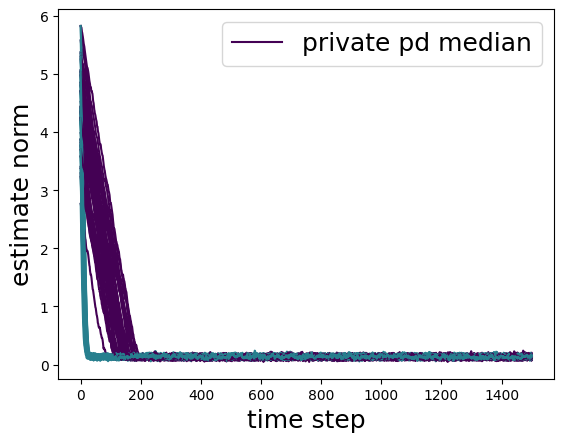

In [13]:
dt='clean'
tau=5
eta=0.01
eps=5

# Simplified wrapper for the experiment function for the clean experiment
def m_experiment(run_number,d,mc_step_size ,nstep_mc,nvec):
    x_p,x=experiment(run_number,fn_dict_med_mad,d,tau,eta,eps,rho,10/ndata,nvec,nstep_mc,mc_step_size,data_type=dt,ndata=ndata)
    return x_p,x


# run the experiment
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    mc_step_size=mc_step_sizes[i]
    nstep_mc=nsteps_mc[i]
    nvec=nvecs[i]
    results=[]
    for j in tqdm(range(num_runs)):
        result_j=m_experiment(j,d, mc_step_size,nstep_mc,nvec)
        if result_j[0]=="Test failed":
            print(j, ' failed')
            # break
        else:
            results.append(result_j)
    plot_and_save(results,d,nstep_mc,data_type=dt,tag='med_mad')
        # #save the chains too in case we want to modify the graphs
    fn="output/delta_med_mad_results_"+dt+"_dimension_"+str(d)+"_med_eps.pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)



starting dimension 20


100%|██████████| 50/50 [27:26<00:00, 32.92s/it]


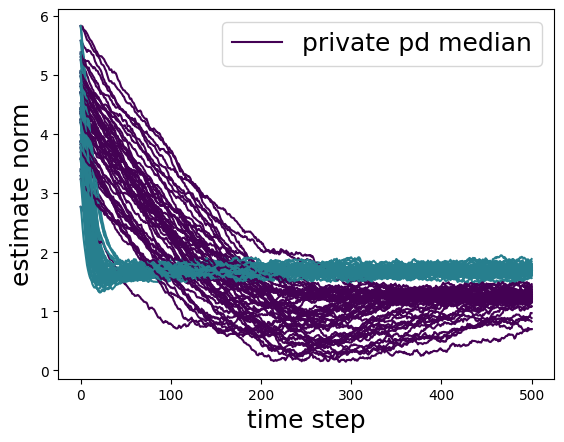

In [13]:
fn_dict_med_mad={'mu': PD_Median_Functions_opt_for_sims.med,
     'sigma': PD_Median_Functions_opt_for_sims.mad,
     'Smu': PD_Median_Functions_opt_for_sims.S_med,
     'Ssigma': PD_Median_Functions_opt_for_sims.S_mad,
     'bhat': PD_Median_Functions_opt_for_sims.b_hat_mad,
    'joint': PD_Median_Functions_opt_for_sims.S_med_mad_b_joint,
    'mad_flag': True
    }
tau=5
eta=0.01
eps=5

# Simplified wrapper for the experiment function for the clean experiment
def m_experiment(run_number,d, mc_step_size ,nstep_mc,nvec):
    x_p,x_np=experiment(run_number,fn_dict_med_mad,d,tau,eta,eps,rho,10/ndata,nvec,nstep_mc,mc_step_size,data_type='con',ndata=ndata)
    return x_p,x_np

# dimensions=[20]
# run the experiment
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    mc_step_size=mc_step_sizes[i]
    nstep_mc=nsteps_mc[i]
    nvec=nvecs[i]
    results=[]
    for j in tqdm(range(num_runs)):
        result_j=m_experiment(j,d, mc_step_size,nstep_mc,nvec)
        if result_j[0]=="Test failed":
            print(j)
            # break
        else:
            results.append(result_j)
    plot_and_save(results,d,nstep_mc,data_type='con',tag='med_mad')
        # #save the chains too in case we want to modify the graphs
    fn="output/delta_med_mad_results_con_dimension_"+str(d)+"_med_eps.pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)

